# Classifying newswires: a multiclass classification example
In this example, we will build a network to classify Reuters newswires into 46 mutually exclusive topics. Because there are many classes and each data point should be classified into only one category, this problem is considered to be a *single-label multiclass classification*. 

### 3.5.1 The Reuters dataset
The Reuters dataset is a set of short newswires and their topics published in 1986. Let's load it from Keras:

In [1]:
from keras.datasets import reuters

# num_words limits to 10,000 most frequently occurring words
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000)

Using TensorFlow backend.


2113536/2110848 [==============================] - 14s    


In [2]:
print "Number of training examples: ", len(train_data)
print "Number of test examples: ", len(test_data)

Number of training examples:  8982
Number of test examples:  2246


In [3]:
# view example
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Each example is a list of intergers (word indices) corresponding to specific words. Here's how we can decode it:

In [4]:
# decode review back to English
word_index = reuters.get_word_index() #dictionary mapping words to integer index

# this reverses the dictionary so we return words instead of numbers
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# This decodes the review. Note indices are offset by 3 because 0, 1, & 2 are...
# reserved indices for "padding," "start of sequence," and "unknown"
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

540672/550378 [============================>.] - ETA: 0s

In [8]:
decoded_newswire

u'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [9]:
# label associated with an example is number between 0 and 45
train_labels[10]

3

### 3.5.2 Preparing the data
Let's vectorize the data.

You can't feed lists of integers into a neural network. You must turn your lists into tensors. There are two ways to do that:
 - Pad lists so they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use the first layer in the network as a layer capable of handling such integer tensors (the Embedding layer).
 - **OR** One-hot encode the lists to turn them into vectors of 0s and 1s. This would mean turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use the first layer as a Dense Layer, capable of handling floating-point vector data.

We will go with the 2nd option of vectorizing the data:

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # creates an all-zero matrix
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # Sets specific indices of results[i] to 1s
    return results

# vectorize training data
x_train = vectorize_sequences(train_data)

# vectorize testing data
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are also two possibilities:
 - Cast the label list as an integer tensor
 - **OR** use one-hot encoding (also called categorical encoding).
 
Here we will use one-hot encoding which consists of embedding each label as an all-zero vector with a 1 in the place of the label index.

In [12]:
# vectorize labels

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# vectorize training labels
one_hot_train_labels = to_one_hot(train_labels)

# vectorize testing labels
one_hot_test_labels = to_one_hot(test_labels)

In [13]:
# Can also use a built-in Keras utility
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [15]:
print train_labels[10]
print one_hot_train_labels[10]

3
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Here we can see the exact change we just made.

### 3.5.3 Building the network
Unlike classifying movie reviews where there were two classes: positive review or negative review, the number of output classes for classifying newswires has gone from 2 to 46, making the dimensionality of the output space much larger.

In a stack of `Dense` layers, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers, each layer potentially becoming a layer bottleneck. In the movie classification we used 16-dimensional intermediate layers, but 16 may be too little to learn to separate 46 different classes, so we will instead use 64 units:

In [16]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
# use softmax activation instead of sigmoid
model.add(layers.Dense(46, activation='softmax'))

Two things to note about our network:
 - The network ends with a `Dense` layer of size 46. For each input sample, the network will output a 46-dimensional vector, and each entry in this vector will encode a different output class.
 - The last layer uses a `softmax` activation. This means the network will output a *probability distribution* over the 46 different output classes.
 
The best loss function to use in this case is `categorical_crossentropy` because it will measure the distance between the probability distribution output by the network and the true distribution of the labels. By minimizing the distance between these two distributions, the network is trained to output something as close as possible to the true labels.

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.5.4 Validating approach
Let's set apart 1,000 samples from the training data to use as the validation set, and then train the network for 20 epochs.

In [18]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [19]:
history = model.fit(partial_x_train, partial_y_train, epochs=20,
                    batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s - loss: 2.5306 - acc: 0.4962 - val_loss: 1.7180 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s - loss: 1.4430 - acc: 0.6878 - val_loss: 1.3435 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s - loss: 1.0929 - acc: 0.7661 - val_loss: 1.1704 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s - loss: 0.8682 - acc: 0.8166 - val_loss: 1.0788 - val_acc: 0.7600
Epoch 5/20
7982/7982 [==============================] - 1s - loss: 0.7020 - acc: 0.8483 - val_loss: 0.9844 - val_acc: 0.7830
Epoch 6/20
7982/7982 [==============================] - 1s - loss: 0.5666 - acc: 0.8796 - val_loss: 0.9401 - val_acc: 0.8030
Epoch 7/20
7982/7982 [==============================] - 2s - loss: 0.4592 - acc: 0.9039 - val_loss: 0.9090 - val_acc: 0.8010
Epoch 8/20
7982/7982 [==============================] - 2s - loss: 0.3704 - a

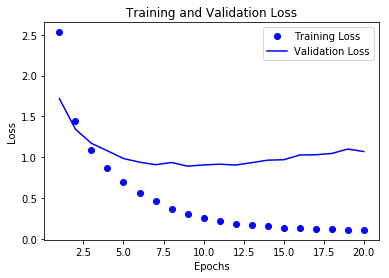

In [21]:
# plot training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

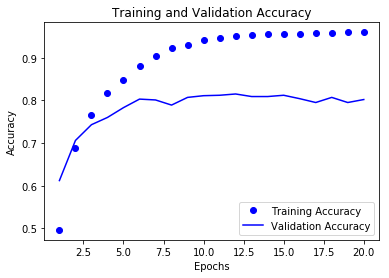

In [22]:
# plot training and validation accuracy
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The network appears to overfit after 9 epochs, so we will train a new network from scratch for nine epochs then evaluate it on the test set:

In [23]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
# use softmax activation instead of sigmoid
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=9,
          batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s - loss: 2.5401 - acc: 0.5226 - val_loss: 1.6792 - val_acc: 0.6540
Epoch 2/9
7982/7982 [==============================] - 2s - loss: 1.3785 - acc: 0.7096 - val_loss: 1.2825 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 2s - loss: 1.0207 - acc: 0.7781 - val_loss: 1.1321 - val_acc: 0.7550
Epoch 4/9
7982/7982 [==============================] - 2s - loss: 0.8003 - acc: 0.8257 - val_loss: 1.0533 - val_acc: 0.7580
Epoch 5/9
7982/7982 [==============================] - 2s - loss: 0.6392 - acc: 0.8629 - val_loss: 0.9746 - val_acc: 0.7950
Epoch 6/9
7982/7982 [==============================] - 2s - loss: 0.5111 - acc: 0.8931 - val_loss: 0.9097 - val_acc: 0.8130
Epoch 7/9
7982/7982 [==============================] - 1s - loss: 0.4115 - acc: 0.9144 - val_loss: 0.8916 - val_acc: 0.8230
Epoch 8/9
7982/7982 [==============================] - 1s - loss: 0.3356 - acc: 0.92

In [24]:
results

[1.0235643176658813, 0.77693677654461679]

This approach reaches an accuracy of about 78%. With a balanced binary classification problem, the accuracy reach by a purely random classifier would be around 50%, but in this case it's close to 18%, so the results seem comparatively good.

In [25]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.182546749777382

### 3.5.5 Generating predictions on new data
Let's verify that the `predict` method of the model instance returns a probability distribution over all 46 topics. Each entry in `predictions` is a vector of length 46 where its coefficients sum to 1 and the largest entry is the predicted class- the class with the highest probability.

In [28]:
predictions = model.predict(x_test)

# vector length
print "Vector length = ", predictions[0].shape

# vector sum
print "Coefficients sum = ", np.sum(predictions[0])

# largest entry
print "Predicted class :", np.argmax(predictions[0])
print "Certainty Percentage: ", np.max(predictions[0])

 Vector length =  (46,)
Coefficients sum =  1.0
Predicted class : 3
Certainty Percentage:  0.97318


### 3.5.6 A different way to handle the labels and the loss
As mentioned earlier, another way to encode the labels would be to cast them as an integer tensor. The only thing this would change is the choice of the loss function. Instead of using `categorical_crossentropy`, we would use `sparse_categorical_crossentropy`:

In [29]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print y_train[10]
print y_test[10]

3
5


In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['acc'])

### 3.5.7 The importance of having sufficiently large intermediate layers
Let's see what happens when we introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional:

In [32]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=20,
          batch_size=128, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s - loss: 2.6578 - acc: 0.3781 - val_loss: 1.9640 - val_acc: 0.5290
Epoch 2/20
7982/7982 [==============================] - 2s - loss: 1.6599 - acc: 0.6196 - val_loss: 1.5352 - val_acc: 0.6230
Epoch 3/20
7982/7982 [==============================] - 2s - loss: 1.3303 - acc: 0.6691 - val_loss: 1.3899 - val_acc: 0.6810
Epoch 4/20
7982/7982 [==============================] - 2s - loss: 1.1407 - acc: 0.7285 - val_loss: 1.3165 - val_acc: 0.7000
Epoch 5/20
7982/7982 [==============================] - 2s - loss: 1.0097 - acc: 0.7453 - val_loss: 1.2639 - val_acc: 0.7040
Epoch 6/20
7982/7982 [==============================] - 2s - loss: 0.9079 - acc: 0.7581 - val_loss: 1.2720 - val_acc: 0.7100
Epoch 7/20
7982/7982 [==============================] - 2s - loss: 0.8277 - acc: 0.7745 - val_loss: 1.2561 - val_acc: 0.7070
Epoch 8/20
7982/7982 [==============================] - 2s - loss: 0.7662 - a

The network now peaks at about 72% validation accuracy, down by over 5%. This is because we are trying to compress a lot of information into an intermediate space that is too low-dimensional.

## 3.5.8 Additional Experiments
### Using larger layers: 128 units

In [33]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=20,
          batch_size=128, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 4s - loss: 1.5673 - acc: 0.6662 - val_loss: 1.0797 - val_acc: 0.7590
Epoch 2/20
7982/7982 [==============================] - 4s - loss: 0.7696 - acc: 0.8282 - val_loss: 0.9420 - val_acc: 0.8090
Epoch 3/20
7982/7982 [==============================] - 4s - loss: 0.4622 - acc: 0.8976 - val_loss: 0.8276 - val_acc: 0.8300
Epoch 4/20
7982/7982 [==============================] - 4s - loss: 0.2981 - acc: 0.9341 - val_loss: 0.9672 - val_acc: 0.8020
Epoch 5/20
7982/7982 [==============================] - 4s - loss: 0.2255 - acc: 0.9446 - val_loss: 0.9684 - val_acc: 0.8020
Epoch 6/20
7982/7982 [==============================] - 4s - loss: 0.1882 - acc: 0.9520 - val_loss: 0.9175 - val_acc: 0.8170
Epoch 7/20
7982/7982 [==============================] - 4s - loss: 0.1683 - acc: 0.9550 - val_loss: 0.9263 - val_acc: 0.8200
Epoch 8/20
7982/7982 [==============================] - 4s - loss: 0.1528 - a

**Previous Validation Accuracy: 81.5%. The max Validation Accuracy here was 83%**.

### Using three hidden layers instead of two

In [34]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=20,
          batch_size=128, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s - loss: 1.8940 - acc: 0.5882 - val_loss: 1.3137 - val_acc: 0.6790
Epoch 2/20
7982/7982 [==============================] - 2s - loss: 1.0165 - acc: 0.7646 - val_loss: 1.1070 - val_acc: 0.7430
Epoch 3/20
7982/7982 [==============================] - 2s - loss: 0.6886 - acc: 0.8463 - val_loss: 0.9448 - val_acc: 0.7910
Epoch 4/20
7982/7982 [==============================] - 2s - loss: 0.4744 - acc: 0.8978 - val_loss: 0.9564 - val_acc: 0.8000
Epoch 5/20
7982/7982 [==============================] - 2s - loss: 0.3437 - acc: 0.9250 - val_loss: 0.9625 - val_acc: 0.8120
Epoch 6/20
7982/7982 [==============================] - 2s - loss: 0.2694 - acc: 0.9386 - val_loss: 1.0245 - val_acc: 0.8130
Epoch 7/20
7982/7982 [==============================] - 2s - loss: 0.2148 - acc: 0.9501 - val_loss: 1.0136 - val_acc: 0.8140
Epoch 8/20
7982/7982 [==============================] - 2s - loss: 0.1891 - a

**Previous Validation Accuracy: 81.5%. The max Validation Accuracy here was 81.4%**.